## **Problem Statement**

### **Business Context**

In the dynamic landscape of the media and news industry, the ability to swiftly categorize and curate content has become a strategic imperative. The vast volume of information demands efficient systems to organize and present content to the audience.

The media industry, being the pulse of information dissemination, grapples with the continuous influx of news articles spanning diverse topics. Ensuring that the right articles reach the right audience promptly is not just a logistical necessity but a critical component in retaining and engaging audiences in an age of information overload.

Common Industry Challenges:
Amidst the ceaseless flow of news, organizations encounter challenges such as:
- Information Overload: The sheer volume of news articles makes manual categorization impractical.
- Timeliness: Delays in categorizing news articles can result in outdated or misplaced content.

### **Problem Definition**

E-news Express, a news aggregation startup, faces the challenge of categorizing the news articles collected. With news articles covering sports, busie=ness, politics, and more, the need for an advanced and automated system to categorize them has become increasingly evident. The manual efforts required for categorizing such a diverse range of news articles are substantial, and human errors in the categorization of news articles can lead to reputational damage for the startup. There is also the factor of delays and potential inaccuracies. To streamline and optimize this process, the organization recognizes the imperative of adopting cutting-edge technologies, particularly machine learning, to automate and enhance the categorization of content.

As a data scientist on the E-news Express data team, the task is to analyze the text in news articles and build a model for categorizing them. The goal is to optimize the categorization process, ensuring timely and personalized delivery.

### **Data Dictionary**

- **Article**: The main body of the news article
- **Category**: The category the article belongs to

## **Please read the instructions carefully before starting the project.**

This is a commented Python Notebook file in which all the instructions and tasks to be performed are mentioned.
* Blanks '_______' are provided in the notebook that
needs to be filled with an appropriate code to get the correct result. With every '_______' blank, there is a comment that briefly describes what needs to be filled in the blank space.
* Identify the task to be performed correctly, and only then proceed to write the required code.
* Please run the codes in a sequential manner from the beginning to avoid any unnecessary errors.
* Add the results/observations (wherever mentioned) derived from the analysis in the presentation and submit the same. Any mathematical or computational details which are a graded part of the project can be included in the Appendix section of the presentation.

**Note**:
1. Please make sure to use Google Colab for this project.
2. Please set the Colab runtime to **T4 GPU** before starting the project.

## **Installing and Importing Necessary Libraries and Dependencies**

In [1]:
# installing the libraries for transformers
!pip install -U -q sentence-transformers transformers bitsandbytes accelerate sentencepiece

ERROR: Exception:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\http\client.py", line 479, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\socket.py", line 708, in readinto
    return self._sock.recv_into(b)
           ^

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', None)

import torch
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

import pickle
# to split the data
from sklearn.model_selection import train_test_split
# to compute performance metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,make_scorer,recall_score,precision_score,f1_score
from sklearn.model_selection import GridSearchCV


# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## **Loading the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Complete the code to read the CSV file
data = pd.read_csv("/content/drive/MyDrive/AIML/projects/NLP/article_data.csv")

## **Data Overview**

In [ ]:
# Write the code to check the first 5 rows of the data
data.head()

,Article,Category
0,"Sudan Govt rejects call to separate religion, state Sudanese rebel leaders #39; demand that Islam be kept out of government in the war-torn region of Darfur, has been rejected by government negotiators.",0
1,Hassan: #39;Abhorrent act #39; says Blair Western political leaders have united to condemn the kidnappers of charity worker Margaret Hassan after a video surfaced apparently showing a militant firing a pistol into the head of a blindfolded woman wearing an orange jumpsuit.,0
2,"Sharon Says Gaza Evacuation Set for 2005 (AP) AP - Israel's evacuation of the Gaza Strip will begin next summer and will take about 12 weeks, Prime Minister Ariel Sharon said Wednesday, reversing an earlier decision to speed up the pullout.",0
3,"Prince Charles chastised for quot;old fashioned quot; views A minister has launched a scathing attack on heir to the throne Prince Charles, accusing him of being quot;very old fashioned quot; and out of touch in his views on teaching in schools.",0
4,"U.S. Says N.Korea Blast Probably Not Nuclear SEOUL (Reuters) - A huge explosion rocked North Korea last week but U.S. and South Korean officials said on Sunday it was unlikely to have been a nuclear weapons test despite the appearance of a ""peculiar cloud"" over the area.",0


In [ ]:
# Write the code to check the shape of the data
data.shape

(4000, 2)

In [ ]:
## Complete the code to check the value counts in Category column
data["Category"].value_counts()

,count
Category,
0,1000
1,1000
2,1000
3,1000


## **Exploratory Data Analysis (EDA)**


In [ ]:
 # function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#### Distribution of category

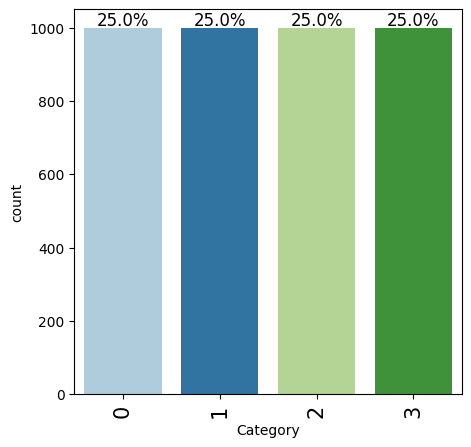

In [ ]:
labeled_barplot(data, "Category", perc=True)   ## Complete the code to get the barplot of Category variable

## **Model Building - Sentence Transformer + ML**

### Defining the SentenceTransformer Model

In [ ]:
## Defining the model.
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Encoding the data

In [ ]:
# setting the compute device
device = "cuda" if torch.cuda.is_available() else "cpu"

## Encoding the dataset.
embedding_matrix = model.encode(data["Article"],show_progress_bar=True,device=device)

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
embedding_matrix[0]

array([ 1.83160808e-02,  6.05401695e-02,  9.90014337e-03, -1.30224274e-02,
       -3.97926234e-02, -3.37697640e-02, -1.42354351e-02, -5.66084944e-02,
        1.32526651e-01,  1.92865939e-03,  1.11181550e-02,  6.64626947e-03,
       -2.14233007e-02, -3.69548239e-02,  7.41015002e-02, -7.16298595e-02,
       -9.33148041e-02, -3.73813845e-02, -4.63653505e-02, -4.12224270e-02,
       -1.77392773e-02,  4.26789522e-02,  2.25535687e-02,  2.16944423e-02,
        6.87402561e-02,  1.08968895e-02,  3.27873006e-02,  1.66175961e-02,
        3.35290432e-02, -2.46533677e-02,  7.89351612e-02, -1.83207504e-02,
       -7.43990019e-02, -4.55265678e-02, -1.29738189e-02,  1.86134465e-02,
        2.11197268e-02,  1.58755537e-02,  3.10996594e-03, -3.31343114e-02,
        6.18378259e-02, -1.94452405e-02, -1.30956515e-03, -8.61609206e-02,
       -6.32115453e-02,  3.13602760e-02, -6.16228022e-03, -9.93304886e-03,
       -6.32374285e-05, -5.72073162e-02,  4.95696068e-02,  5.64293042e-02,
       -3.16364691e-02,  

### Train-Test Split

In [ ]:
# Split the data
X = embedding_matrix
y = data["Category"]

In [ ]:
# Initial split into training (80%) and testing (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)

# Further split the temporary set into validation (10%) and test (10%) sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [ ]:
print("Shape of the set of input variables for training:", X_train.shape)    # Complete the code to get the shape of training input data
print("Shape of the set of input variables for validation:", X_valid.shape)    # Complete the code to get the shape of validation input data
print("Shape of the set of input variables for testing:", X_test.shape)     # Complete the code to get the shape of testing input data

Shape of the set of input variables for training: (3200, 384)
Shape of the set of input variables for validation: (400, 384)
Shape of the set of input variables for testing: (400, 384)


In [ ]:
print("Shape of the set of output variables for training:", y_train.shape)    # Complete the code to get the shape of training output data
print("Shape of the set of output variables for validation:",y_valid.shape)    # Complete the code to get the shape of validation output data
print("Shape of the set of output variables for testing:",y_test.shape)     # Complete the code to get the shape of testing output data

Shape of the set of output variables for training: (3200,)
Shape of the set of output variables for validation: (400,)
Shape of the set of output variables for testing: (400,)


### Random Forest Model (base)

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred,average="weighted")  # to compute Recall
    precision = precision_score(target, pred,average="weighted")  # to compute Precision
    f1 = f1_score(target, pred,average="weighted")  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
## Building the model
rf = RandomForestClassifier(random_state = 42)

## Compete the code to fit the model on X_train and y_train
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

**Confusion Matrix**

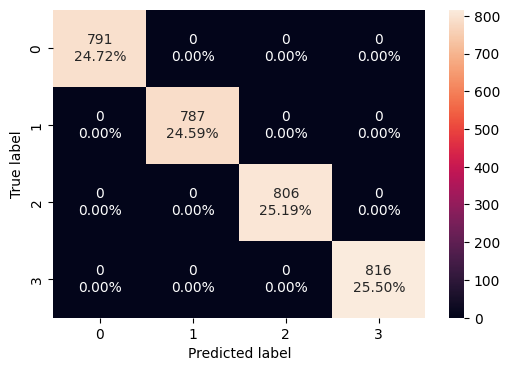

In [ ]:
## To get the confusion matrix on X_train and y_train
confusion_matrix_sklearn(rf, X_train, y_train)

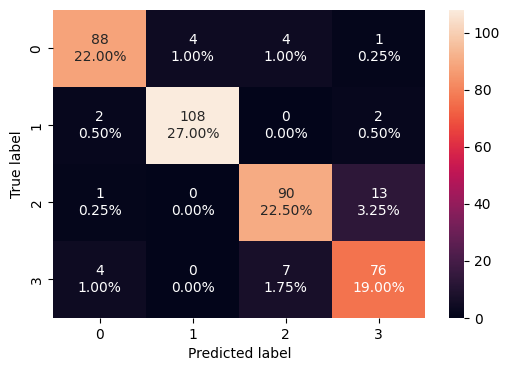

In [ ]:
## Write the code to get the confusion matrix for X_valid and y_valid
confusion_matrix_sklearn(rf, X_valid, y_valid)

In [ ]:
# Predicting on train data
y_pred_train = rf.predict(X_train)

# Predicting on validation data
y_pred_valid = rf.predict(X_valid)

**Classification report**

In [ ]:
## Classification report for train data
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       791
           1       1.00      1.00      1.00       787
           2       1.00      1.00      1.00       806
           3       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [ ]:
## Write the code to get the classification report for validation data
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        97
           1       0.96      0.96      0.96       112
           2       0.89      0.87      0.88       104
           3       0.83      0.87      0.85        87

    accuracy                           0.91       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.91      0.91      0.91       400



In [ ]:
## Storing the metrics
rf_train_perf = model_performance_classification_sklearn(
    rf, X_train, y_train
)

In [ ]:
## Storing the metrics
rf_valid_perf = model_performance_classification_sklearn(
    rf, X_valid, y_valid
)

### Random Forest (with class_weights)

In [ ]:
## Building the model
rf_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)

## Complete the code to fit the model on X_train and y_train
rf_balanced.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

**Confusion Matrix**

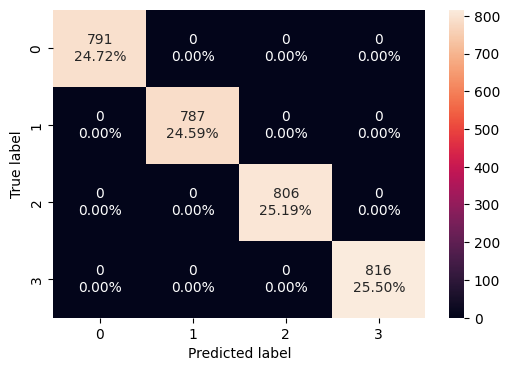

In [ ]:
## To get the confusion matrix on X_train and y_train
confusion_matrix_sklearn(rf_balanced, X_train, y_train)

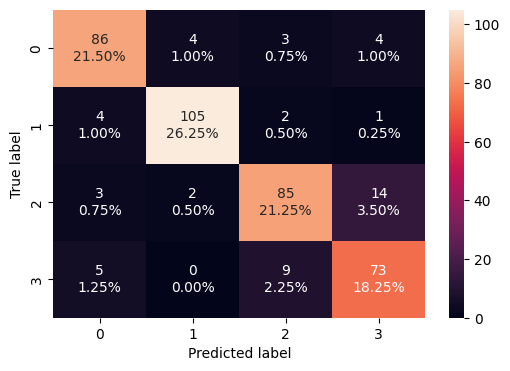

In [ ]:
## Write the code to get the confusion matrix for X_valid and y_valid
confusion_matrix_sklearn(rf_balanced, X_valid, y_valid)

In [ ]:
## Predicting on train data
y_pred_train = rf_balanced.predict(X_train)

## Complete the code to predict the model on X_valid
y_pred_valid = rf_balanced.predict(X_valid)

**Classification report**

In [ ]:
## Classification report for train data
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       791
           1       1.00      1.00      1.00       787
           2       1.00      1.00      1.00       806
           3       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [ ]:
## Write the code to get the classification report for validation data
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88        97
           1       0.95      0.94      0.94       112
           2       0.86      0.82      0.84       104
           3       0.79      0.84      0.82        87

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [ ]:
## Storing the metrics
rf_bal_train_perf = model_performance_classification_sklearn(
    rf_balanced, X_train, y_train
)

In [ ]:
## Complete the code to store the metrics of validation data
rf_bal_valid_perf = model_performance_classification_sklearn(
    rf_balanced, X_valid,y_valid
)

### Random Forest (with hyperparamter tuning)

In [ ]:
## Building the model
rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

## Defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 10, 3)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6],
    "n_estimators": np.arange(30, 70, 15),
}

## Defining the type of scoring used to compare parameter combinations
## We need to specify the mechanism of averaging as we have more than 2 target classes
scorer = make_scorer(recall_score, average='weighted')

## Running the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)

## Complete the code to fit the model on X_train and y_train
grid_obj = grid_obj.fit(X_train, y_train)

In [ ]:
## Creating a new model with the best combination of parameters
rf_tuned = grid_obj.best_estimator_

## Complte the code to fit the new model to X_train and y_train
rf_tuned.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7,
                       min_samples_split=6, n_estimators=60, random_state=42)

**Confusion Matrix**

In [ ]:
## Write the code to get the classification report for train data
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       791
           1       1.00      1.00      1.00       787
           2       1.00      1.00      1.00       806
           3       1.00      1.00      1.00       816

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [ ]:
## Write the code to get the classification report for validation data
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88        97
           1       0.95      0.94      0.94       112
           2       0.86      0.82      0.84       104
           3       0.79      0.84      0.82        87

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [ ]:
## Complete the code to predict the model on train data
y_pred_train = rf_tuned.predict(X_train)

## Complete the code to predict the model on validation data
y_pred_valid = rf_tuned.predict(X_valid)

**Classification report**

In [ ]:
## Write the code to get the classification report for train data
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       791
           1       0.97      0.99      0.98       787
           2       0.94      0.95      0.95       806
           3       0.96      0.95      0.96       816

    accuracy                           0.96      3200
   macro avg       0.96      0.96      0.96      3200
weighted avg       0.96      0.96      0.96      3200



In [ ]:
## Write the code to get the classification report for validation data
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        97
           1       0.92      0.96      0.94       112
           2       0.89      0.82      0.85       104
           3       0.79      0.89      0.84        87

    accuracy                           0.89       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.89      0.89      0.89       400



In [ ]:
## Complete the code to store the metrics of train data
rf_tuned_train_perf = model_performance_classification_sklearn(
    rf_tuned, X_train,y_train
)

In [ ]:
## Complete the code to store the metrics of validation data
rf_tuned_valid_perf = model_performance_classification_sklearn(
    rf_tuned, X_valid, y_valid
)

## **Model Building - Transformer**

### Target Mapping

In [ ]:
class_map = {0:"World",1:"Sports",2:"Business",3:"Sci/Tech"}

In [ ]:
class_map

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

In [ ]:
reverse_class_map = {}
for key,value in class_map.items():
    reverse_class_map[value]=key

reverse_class_map

{'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}

### Defining the Tokenizer

In [ ]:
## Initializing a T5 tokenizer using the pre-trained model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
pip install "transformers>=4.45.1"

### Defining the Model

In [ ]:
## Initializing a T5 model for conditional generation using the pre-trained model "google/flan-t5-large"
#model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", load_in_8bit=True, device_map="auto")
## Initializing a T5 tokenizer using the pre-trained model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
t5_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", load_in_8bit=True, device_map="auto")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### Functions for making predictions

In [ ]:
## Defining a function to compute different metrics.

def model_performance_classification(pred, target):
    """
    Function to compute different metrics to check classification model performance

    pred : prediction of the target variable.
    target: dependent variable
    """


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred,average="weighted")  # to compute Recall
    precision = precision_score(target, pred,average="weighted")  # to compute Precision
    f1 = f1_score(target, pred,average="weighted")  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
## Creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = ['World','Sports','Business','Sci/Tech']
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
## Defining a function to generate, process, and return a response
def generate_response(prompt):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")    ### using the tokenizer to create tokens in tensor format from an input
    outputs = t5_model.generate(input_ids, max_length=16, do_sample=True, temperature=0.001)    ### generating the model output in tensor format
    return tokenizer.decode(outputs[0])[6:-4]    ### using the tokenizer to decode the model output, and then return it

In [ ]:
## Checking a customer review and it's sentiment
print('Article:\t', data.iloc[4]["Article"])
print('Actual Category:\t', class_map[y[4]])

Article:	 U.S. Says N.Korea Blast Probably Not Nuclear  SEOUL (Reuters) - A huge explosion rocked North Korea last  week but U.S. and South Korean officials said on Sunday it was  unlikely to have been a nuclear weapons test despite the  appearance of a "peculiar cloud" over the area.
Actual Category:	 World


### Base Prompt for Prediction

In [ ]:
## Defining a prompt which tells the model what to do
sys_prompt = """
    You are a helpful assistant. Please identify  the category of the news article from one among these: {'World', 'Sports', 'Business', 'Sci/Tech'}
"""

## Predicting the category using the model by incorporating the system prompt and the provided review text

pred_sent = generate_response(
    """
        {}
        news article: '{}'
    """.format(sys_prompt, X[4])
)

print(pred_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (3360 > 512). Running this sequence through the model will result in indexing errors


Sci/Tech


In [ ]:
## Defining a function to generate a sentiment prediction
def predict_category(news_article):
    pred = generate_response(
        """
            {}
            news article: '{}'
        """.format(sys_prompt,news_article)
    )

    if "Sports" in pred:
       pred="Sports"
    elif "Business" in pred:
       pred="Business"
    elif "World" in pred:
       pred="World"
    else:
      pred="Sci/Tech"

    return reverse_class_map[pred]

In [ ]:
## Selecting and assigning specific columns
X_train = data.iloc[y_train.index]["Article"]
X_valid = data.iloc[y_test.index]["Article"]
X_test = data.loc[y_valid.index]["Article"]

In [ ]:
## Applying predict_category function on the train and validation data
y_pred_train_flan = X_train.apply(predict_category)
y_pred_valid_flan = X_valid.apply(predict_category)

In [ ]:
print(y_pred_train_flan.head())
print("\n")
print(y_train.head())
print(X_train.head())
print(y_valid.head())
print(y_pred_valid_flan.head())


3994    3
423     0
2991    3
1221    1
506     0
Name: Article, dtype: int64


3994    3
423     0
2991    2
1221    1
506     0
Name: Category, dtype: int64
3994                                                                                                                                                   NASA braces for Frances Thousands of automobiles clogged Florida #39;s highways during the largest evacuation in state history as residents anticipated the arrival of Hurricane Frances.
423     Spanish PM to host French, German allies in Madrid summit (AFP) AFP - Sealing ratification of an EU constitution and the question of terrorism will top the agenda when Spanish Prime Minister Jose Luis Rodriguez Zapatero welcomes French President Jacques Chirac and German Chancellor Gerhard Schroeder to a summit meeting Monday.
2991                                                                                                                                   Study: 400K Fewer Tech Jobs Sinc

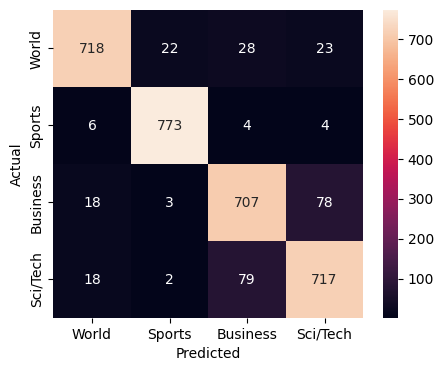

In [ ]:
## Plotting the confusion matrix
plot_confusion_matrix(y_train, y_pred_train_flan)

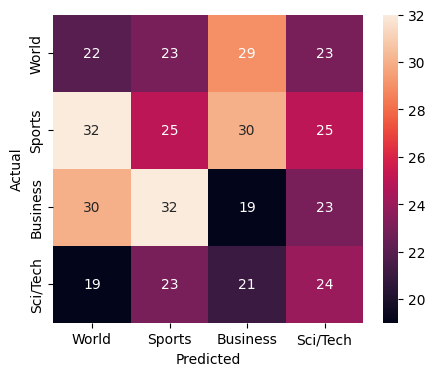

In [ ]:
## Complete the code to get the confusion matrix for validation data
plot_confusion_matrix(y_valid,y_pred_valid_flan)

In [ ]:
## Getting the classification report for train data
print(classification_report(y_train, y_pred_train_flan))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       791
           1       0.97      0.98      0.97       787
           2       0.86      0.88      0.87       806
           3       0.87      0.88      0.88       816

    accuracy                           0.91      3200
   macro avg       0.91      0.91      0.91      3200
weighted avg       0.91      0.91      0.91      3200



In [ ]:
## Complete the code to get the classification report for validation data
print(classification_report(y_valid,y_pred_valid_flan))

              precision    recall  f1-score   support

           0       0.21      0.23      0.22        97
           1       0.24      0.22      0.23       112
           2       0.19      0.18      0.19       104
           3       0.25      0.28      0.26        87

    accuracy                           0.23       400
   macro avg       0.23      0.23      0.23       400
weighted avg       0.22      0.23      0.22       400



In [ ]:
## Storing the metrics
flan_train_base = model_performance_classification(y_pred_train_flan,y_train)
flan_valid_base = model_performance_classification(y_pred_valid_flan,y_valid)

In [ ]:
data[data["Category"]==3]

,Article,Category
3000,"When Wireless Networks Merge Now that its \$41 billion takeover of AT T Wireless has been completed, Cingular will spend hundreds of millions of dollars in coming weeks on its advertising campaign.",3
3001,"Microsoft Updates SQL Server 2005 Microsoft today announced the availability of the second Community Technology Preview (CTP) for Microsoft SQL Server 2005 and the technical preview availability of SQL Server 2005 Express Manager, a new, free database management tool.",3
3002,"HP Hugs JBoss Tighter HP (Quote, Chart) deepened its relationship with open source software concern JBoss, agreeing to become a major source of support for its application server and Linux.",3
3003,Music lovers can download entire track on their Mobile Phone Here is good news for music lovers! Now you can download the entire track on your mobile phone. This is made possible as two giants US-based Melodeo and Warner Music Group has signed an agreement whereby consumers,3
3004,Older mobiles may cause tumours: study The Institute of Environmental Medicine (IMM) at Karolinska Institute in Sweden found no indications of risk for less than 10 years of usage.,3
...,...,...
3995,"Time on a Chip: The Incredible Shrinking Atomic Clock Researchers are developing tiny atomic clocks that could be made using standard semiconductor processes and slipped into cellphones, hand-held computers and global positioning system receivers.",3
3996,"NASA Puts Hands-Free Linkup to a Test Tuesday, barring a weather-caused delay, for the first time the United States will send an autonomous robot vehicle to join up with a satellite and conduct a 20-hour demonstration of its abilities -- without any human guidance.",3
3997,"Airborne Cell-Phone Ban Likely to Remain for Now (Reuters) Reuters - Hopes -- and worries -- that U.S.\regulators will soon end the ban on using wireless phones\during U.S. commercial flights are likely at least a year or\two early, government officials and analysts say.",3
3998,"Gold Indian Coin Expected to Fetch #36;27,000 (Reuters) Reuters - An Indian gold coin which is nearly\1,900 years old and shows one of the earliest depictions of\Buddha is to be sold at auction where it is expected to fetch\up to 15,000 pounds ( #36;27,000).",3


### Improved Prompt for Prediction

In [ ]:
# defining a prompt which tells the model what to do
sys_prompt = """
    Please categorize the news articles into one of the following: {'World', 'Sports', 'Business', 'Sci/Tech'}
    using exmaples below:
    Article   Category
    Sudan Govt rejects call to separate religion, state Sudanese rebel leaders #39; demand that Islam be kept out of government in the war-torn region of Darfur, has been rejected by government negotiators.   Sports
    AUBURN 21, ALABAMA 13 Auburn #39;s Strong Second Half Keeps It in &lt;b&gt;...&lt;/b&gt; For one half Saturday, the controversy over the Bowl Championship Series looked like it might disappear in the dampness of Bryant-Denny Stadium as undefeated Auburn found itself in a fight with archrival Alabama.  Business
    Aisin finishes deal for Michigan land HANDY TOWNSHIP -- A Japanese auto supplier said Thursday it completed the purchase of about 750 acres of Michigan land for a proving ground.   World
    When Wireless Networks Merge Now that its \$41 billion takeover of AT T Wireless has been completed, Cingular will spend hundreds of millions of dollars in coming weeks on its advertising campaign.  Sci/Tech

"""

# predicting the sentiment using the model by incorporating the system prompt and the provided review text

pred_sent = generate_response(
    """
        {}
        news article: '{}'
    """.format(sys_prompt, X[4])
)

print(pred_sent)

Sci/Tech


In [ ]:
## Applying predict_category function on the train and validation data
y_pred_train_flan_imp = X_train.apply(predict_category)
y_pred_valid_flan_imp = X_valid.apply(predict_category)

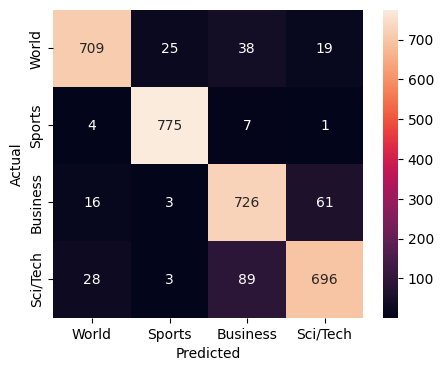

In [ ]:
## Plotting the confusion matrix for train data
plot_confusion_matrix(y_train, y_pred_train_flan_imp)

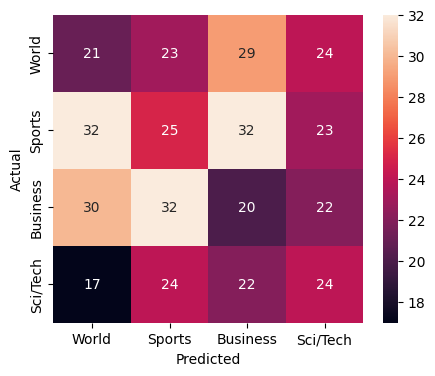

In [ ]:
## Complete the codet to get the confusion matrix for validation data
plot_confusion_matrix(y_valid, y_pred_valid_flan_imp)

In [ ]:
## Getting the classification report for train data
print(classification_report(y_train, y_pred_train_flan_imp))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       791
           1       0.96      0.98      0.97       787
           2       0.84      0.90      0.87       806
           3       0.90      0.85      0.87       816

    accuracy                           0.91      3200
   macro avg       0.91      0.91      0.91      3200
weighted avg       0.91      0.91      0.91      3200



In [ ]:
## Complete the code to get the classification report for validation data
print(classification_report(y_valid, y_pred_valid_flan_imp))

              precision    recall  f1-score   support

           0       0.21      0.22      0.21        97
           1       0.24      0.22      0.23       112
           2       0.19      0.19      0.19       104
           3       0.26      0.28      0.27        87

    accuracy                           0.23       400
   macro avg       0.23      0.23      0.23       400
weighted avg       0.22      0.23      0.22       400



In [ ]:
## Storing the metrics
flan_train_imp = model_performance_classification(y_pred_train_flan_imp,y_train)
flan_valid_imp = model_performance_classification(y_pred_valid_flan_imp,y_valid)

## **Model Performance Comparison and Final Model Selection**

In [ ]:
## Training performance comparison

models_train_comp_df = pd.concat(
    [
        rf_train_perf.T,
        rf_bal_train_perf.T,
        rf_tuned_train_perf.T,
        flan_train_base.T,
        flan_train_imp.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Random Forest(base)",
    "Random Forest with class_weights",
    "Random Forest(tuned)",
    "Flan (base prompt)",
    "Flan (improvised prompt)"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Random Forest(base),Random Forest with class_weights,Random Forest(tuned),Flan (base prompt),Flan (improvised prompt)
Accuracy,1.0,1.0,0.960313,0.910937,0.908125
Recall,1.0,1.0,0.960313,0.910937,0.908125
Precision,1.0,1.0,0.960351,0.911288,0.909039
F1,1.0,1.0,0.960243,0.910990,0.908074


In [ ]:
## Validation set performance comparison
models_valid_comp_df = pd.concat(
    [
        rf_valid_perf.T,
        rf_bal_valid_perf.T,
        rf_tuned_valid_perf.T,
        flan_valid_base.T,
        flan_valid_imp.T
    ],
    axis=1,
)
models_valid_comp_df.columns = [
    "Random Forest(base)",
    "Random Forest with class_weights",
    "Random Forest(tuned)",
    "Flan (base prompt)",
    "Flan (improvised prompt)"
]
print("Validation set performance comparison:")
models_valid_comp_df

Validation set performance comparison:


,Random Forest(base),Random Forest with class_weights,Random Forest(tuned),Flan (base prompt),Flan (improvised prompt)
Accuracy,0.905000,0.872500,0.885000,0.225000,0.225000
Recall,0.905000,0.872500,0.885000,0.225000,0.225000
Precision,0.905989,0.873485,0.887658,0.224604,0.224847
F1,0.905277,0.872711,0.885004,0.224499,0.224757


**Pick the best model from the above table and apply on test data**

In [ ]:
## Assigns test rows based on index
X_test = embedding_matrix[y_test.index]

None


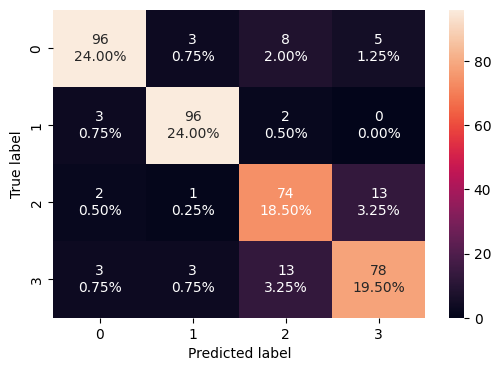

In [ ]:
print(confusion_matrix_sklearn(rf_balanced, X_test, y_test))

In [ ]:
# Predicting on test data
y_pred_test = rf_balanced.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       112
           1       0.93      0.95      0.94       101
           2       0.76      0.82      0.79        90
           3       0.81      0.80      0.81        97

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



## **Actionable Insights and Recommendations**

1. The performance of the model on train /test data is good in RandomForest predictions where as on validation data not so good in the T5Model. This might be because validation data also might need to be finetuned or balanced
into the 4 categories data. 2.There is a lot of scope for improvement in the prompt.

-





---

